# ロジステック回帰分析でアヤメ(iris)を分類してみました #

## この記事の目的 ##
scikit-learnによる機械学習の基本的な流れを忘れない様にまとめてみました。この記事では、機械学習の例題用データとして有名なirisのデータを使って分類問題を解いてみました。この記事で基本的な分類問題を解く機械学習の流れがわかると思います。

## 分類の流れ ##
1. データの読み込み
2. データ前処理(データ分割、標準化)
3. 主成分分析による特徴量の選択
4. ロジスティック回帰モデルの学習(グリッドサーチによるハイパーパラメータの調整)
5. モデルの評価

# 1. データ読み込み #
scikit-learnに用意されているirisのデータを読み込んでpandasのデータフレームに変換します。pandasのデータフレームに変換することでpandasで用意されている関数をデータに適用できるので便利です。試しに読み込んだデータの統計量を表示する関数を実行しています。

In [1]:
from sklearn.datasets import load_iris
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

iris_data = load_iris()
iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df["target"] = iris_data.target

#データを表示
display(iris_df.head())
display(iris_df.tail())

#データの統計量の表示
display(iris_df.describe())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


# 2. データの前処理 #
読み込んだデータを機械学習に適した形式にしていきます。通常データは、データの欠損やスケールの不一致など、機械学習に適していない状態で存在しているので機械学習で使用できるようにします。前処理の良し悪しによって学習結果の良し悪しが決まる重要な工程なので、機械学習を行う上で多くの時間と労力を費やすことになります。今回は簡単に以下の事を実施しました。

- データの分割(学習用、検証用)
- データの標準化
- 主成分分析による特徴量の選択

### データの分割と標準化 ###

In [2]:
#学習用(&検証用)データとテスト用データを分ける
x_train, x_test, y_train, y_test = train_test_split(
    iris_df.iloc[:, 0:4],
    iris_df.iloc[:, 4],
    test_size = 0.3,
    random_state=1
)

#データの標準化
scl = StandardScaler()
scl.fit(x_train) #学習用データで標準化
x_train_std = scl.transform(x_train)
x_test_std = scl.transform(x_test)

# 3. 主成分分析による特徴量の選択 #
読み込んだデータには４つの特徴量があることがわかります。特徴量が多いと学習効率が悪くなるので可能であれば使用する特徴量を減らそうと思います。そこでどの特徴量を使用するかを主成分分析で決めていきます。

In [3]:
from sklearn.decomposition import PCA
import numpy as np

pca=PCA()
pca.fit(x_train_std)
# display(pca.explained_variance_ratio_)
tot = sum(pca.explained_variance_ratio_)
print("寄与率:", str(["{:.1f}%".format(val * 100/tot)  for val in pca.explained_variance_ratio_]))

寄与率: ['72.2%', '23.5%', '4.0%', '0.4%']


主成分分析を実行したら主成分軸のpc1とpc2の寄与が高いことがわかります。そこで試しにpc1とpc2から成る２次元空間にデータを射影してみましょう。まずは変換後の次元が２次元になるように主成分分析を改めて実行した後にデータを射影したものを下に図示しました。

In [4]:
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
pca.fit(x_train_std)
x_train_pca = pca.transform(x_train_std)

def show_scatter(x, y):
    markers = ["s", "x", "v"]
    for idx, label in enumerate(np.unique(y_train)):
        plt.scatter(
            x=x[y == label, 0], 
            y=x[y == label, 1],
            marker = markers[idx],
            label = label
        )
    plt.xlabel("pc1")
    plt.ylabel("pc2")
    plt.show()

print("データをpc1, pc2に射影した図")
show_scatter(x_train_pca, y_train)

データをpc1, pc2に射影した図


<Figure size 640x480 with 1 Axes>

 上図を見るとpc1とpc2でうまく分類できそうですね。では、このpc1とpc2はどの様な特徴量を表しているのか確かめてみます。そのためには、元の特徴量をpc1, pc2の空間に射影します。

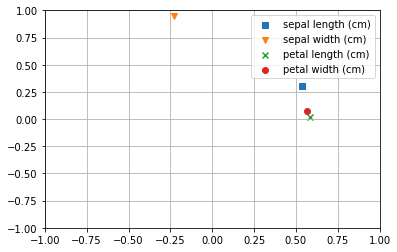

In [5]:
axis = np.array(
    [[1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]],
    np.float
)

axis_pca = pca.transform(axis)
markers = ["s", "v", "x", "o"]
for idx, val in enumerate(range(4)):
    plt.scatter(
        x = axis_pca[idx, 0], 
        y = axis_pca[idx, 1],
        marker = markers[idx],
        label = iris_df.columns[idx]
    )
plt.legend()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.show()

上図は元の特徴ベクトルをpc1, pc2に射影したものです。図より"sepal width"以外の特徴量は近い位置に存在していて似た情報であることがわかります。よって、分類問題で使用する特徴量としては"sepal width"と"petal length"を使用することにします。

# 4. ロジステック回帰モデルの学習#
使用する特徴量が決まったので、ロジステック回帰モデルをデータに適用して分類してみたいと思います。また、精度をあげるためにグリッドサーチによるハイパーパラメータの調整を行いました。

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
params = {"C": [0.001, 1, 10 , 100, 1000]}
rg = LogisticRegression()
grid = GridSearchCV(
    estimator = rg,
    param_grid = params,
    cv = 5
)
grid.fit(x_train_std[:, [1, 2]], y_train)
print("{:.2f}%".format(grid.score(x_train_std[:, [1, 2]], y_train) * 100))

93.33%


ハイパーパラメータを調整した結果、学習データで93.3%の正解率となりました。良さそうなモデルです!!では、グリッドサーチによるパラメータの調整結果を見ると"C"の調整結果は"C"=100となっていることがわかります。"C"は正則化に関するパラメータでモデルの過学習を予防します。

In [7]:
print(grid.best_score_)
print(grid.best_params_)

0.9238095238095239
{'C': 1000}


# 5. モデルの評価 #
最後に学習したモデルの評価を行います。モデルの評価には学習で使用したデータとは別のデータを使用します。今回は、検証用に用意したデータを用いて正解率を計算してみます。正解率とはモデルが正しく予想したデータの割合のことです。

In [8]:
from sklearn.metrics import accuracy_score
print( "正解率:{:.2f}%".format(accuracy_score(y_test, grid.predict(x_test_std[:, [1, 2]])) * 100 ))

正解率:95.56%


検証用データを使用した正解率は95.5%となかなかの結果が出ました。

# 6. まとめ #
以上が分類問題を機械学習で解く場合の基本的な流れです。今回紹介した流れは僕が勉強したことを僕の理解の範囲内でまとめたものにすぎません、よってもっと適切な方法があるはずです。でも、まあ入門としては及第点ですかね？今後さらに勉強して、いろいろなモデルや評価方法を試していきたいと思います。

# おまけ#
scikit-learnを使用しない主成分分析の方法をメモっておきます。

In [9]:
# scikit-learnを使用しないでPCAを実行する
import numpy as np

# 共分散行列
cov_mat = np.cov(x_train_std.T)
# 固有値と固有ベクトル
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
# 分散説明率(寄与率)
tot = sum(eigen_vals)
cont_rate = [val / tot for val in eigen_vals]
print(["{:.2f}".format(i) for i in cont_rate])

['0.72', '0.23', '0.04', '0.00']
